Welcome to the Pyro implementation of my hierarchical fantasy football model.  This is my "main" model and the one I have done the most work on.  Much of this notebook is the same as the "flat" model so I will not repeat all of the details mentioned there; I will focus on describing the additions and details of this notebook that are specific to the hierarchical model.  

In [1]:
%pip install pyro-ppl
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt

import numpy as np
import pandas

Notice we replace the team names of two NFL teams.  The background information is that the San Diego Chargers moved to Los Angeles and the St. Louis Rams also moved to Los Angeles recently.  The reason for making the replacement in the data is that, in this model, we model each NFL team separately so teams (such as the LAC and LAR) who have only been around for a few years only have a few data points; we instead combine these new teams with their former team name to extend the history and increase the sample size.  

In [2]:
# data
data = pandas.read_csv("https://raw.githubusercontent.com/iandardik/CS7290_project/master/data.csv")
data = data.dropna()
data.replace(to_replace="SDG", value="LAC", inplace=True) # San Diego Chargers moved to become the LA Chargers
data.replace(to_replace="STL", value="LAR", inplace=True) # St. Louis Rams moved to become the LA Rams
data

,Player,ID,Team,Age,Position,Games,Games Started,Attempts,Yards,TD,1D,Lng,Y/A,Y/G,Fumbles,Year,Points,Yards Next Year,TD Next Year,Fumbles Next Year,Y/G Next Year,Games Next Year,Attempts Next Year,Points Next Year
0,Eddie George,GeorEd00,TEN,27,RB,16,16,403,1509,14,78,35,3.7,94.3,5,2000,224.9,939.0,5.0,8.0,58.7,16.0,315.0,107.9
1,Edgerrin James,JameEd00,IND,22,RB,16,16,387,1709,13,100,30,4.4,106.8,5,2000,238.9,662.0,3.0,3.0,110.3,6.0,151.0,78.2
2,Jerome Bettis,BettJe00,PIT,28,RB,16,16,355,1341,8,72,30,3.8,83.8,1,2000,180.1,1072.0,4.0,3.0,97.5,11.0,225.0,125.2
3,James Stewart,StewJa00,DET,29,RB,16,16,339,1184,10,66,34,3.5,74.0,4,2000,170.4,685.0,1.0,0.0,62.3,11.0,143.0,74.5
4,Stephen Davis,DaviSt00,WAS,26,RB,15,15,332,1318,11,72,50,4.0,87.9,4,2000,189.8,1432.0,5.0,6.0,89.5,16.0,356.0,161.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6356,Jarvis Landry,LandJa00,CLE,27,WR,16,16,1,10,0,1,10,10.0,0.6,0,2019,1.0,10.0,1.0,2.0,0.7,15.0,4.0,3.0
6361,Anthony Miller,MillAn02,CHI,25,WR,16,7,1,-1,0,0,-1,-1.0,-0.1,1,2019,-2.1,12.0,0.0,2.0,0.8,16.0,2.0,-2.8
6368,Allen Robinson,RobiAl02,CHI,26,WR,16,15,1,2,0,0,2,2.0,0.1,0,2019,0.2,-1.0,0.0,0.0,-0.1,16.0,1.0,-0.1
6374,Michael Thomas,ThomMi05,NOR,26,WR,16,15,1,-9,0,0,-9,-9.0,-0.6,1,2019,-2.9,1.0,0.0,0.0,0.1,7.0,1.0,0.1


In [3]:

all_teams = np.unique(data["Team"].to_numpy())
num_teams = len(all_teams)
all_teams

array(['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL',
       'DEN', 'DET', 'GNB', 'HOU', 'IND', 'JAX', 'KAN', 'LAC', 'LAR',
       'MIA', 'MIN', 'NOR', 'NWE', 'NYG', 'NYJ', 'OAK', 'PHI', 'PIT',
       'SEA', 'SFO', 'TAM', 'TEN', 'WAS'], dtype=object)

In [4]:
team_to_idx = {}
for i,team in enumerate(all_teams):
    team_to_idx[team] = i
data["Team Index"] = [team_to_idx[tm] for tm in data["Team"]]

In [5]:
att_key = "Attempts"
paot_key = "Percent Attempts Of Team"
percent_attempts_per_player = {}

for year in range(2000, 2020):
    percent_attempts_per_player[year] = {}
    year_data = data[data["Year"]==year]
    for team in all_teams:
        members = year_data[year_data["Team"]==team]
        ids = members["ID"].to_numpy()
        attempts = members[att_key].to_numpy()
        if len(attempts) > 0:
            total = sum(attempts)
            attempt_perc = np.array([a/total for a in attempts])
            for id, perc in zip(ids,attempt_perc):
                percent_attempts_per_player[year][id] = perc

papp_list = []
for i,row in data.iterrows():
    year = row["Year"]
    id = row["ID"]
    perc = percent_attempts_per_player[year][id]
    papp_list.append(perc)

data[paot_key] = papp_list
data = data[data[paot_key] < 1.0]

# sanity checks for percent attempts of team
for a in data[paot_key].to_numpy():
    assert(a > 0 and a < 1)

for year in range(2000, 2020):
    year_data = data[data["Year"]==year]
    for team in all_teams:
        atts = year_data[year_data["Team"]==team][paot_key]
        if len(atts) > 0:
            total = sum(atts)
            if not np.isclose(total, 1.0):
                print("total: {}".format(total))
                print("team: {}, year: {}".format(team, year))
            assert(np.isclose(total, 1.0))


In [6]:

att_key = "Attempts Next Year"
paot_key = "Percent Attempts Of Team Next Year"
percent_attempts_per_player = {}

for year in range(2000, 2020):
    percent_attempts_per_player[year] = {}
    year_data = data[data["Year"]==year]
    for team in all_teams:
        members = year_data[year_data["Team"]==team]
        ids = members["ID"].to_numpy()
        attempts = members[att_key].to_numpy()
        if len(attempts) > 0:
            total = sum(attempts)
            attempt_perc = np.array([a/total for a in attempts])
            for id, perc in zip(ids,attempt_perc):
                percent_attempts_per_player[year][id] = perc

papp_list = []
for i,row in data.iterrows():
    year = row["Year"]
    id = row["ID"]
    perc = percent_attempts_per_player[year][id]
    papp_list.append(perc)

data[paot_key] = papp_list
data = data[data[paot_key] < 1.0]

# sanity checks for percent attempts of team
for a in data[paot_key].to_numpy():
    assert(a > 0 and a < 1)

for year in range(2000, 2020):
    year_data = data[data["Year"]==year]
    for team in all_teams:
        atts = year_data[year_data["Team"]==team][paot_key]
        if len(atts) > 0:
            total = sum(atts)
            if not np.isclose(total, 1.0):
                print("total: {}".format(total))
                print("team: {}, year: {}".format(team, year))
            assert(np.isclose(total, 1.0))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
target_year = 2020
holdout = data[data["Year"]==target_year-1]
data = data[data["Year"] < target_year-1]

The minimum sample size that we found for a team is 17 data points.  Unfortunately this is rather low, but it is still useful for generating a good posterior distribution.  We truncate all data to have length of 17 per team so we can run the NUTS inference algorithm.  

In [8]:
num_obs = 17

```observed_percent_attempts``` and ```observed_percent_attempts_NY``` still hold observations for the percent of attempts for each player on their team in a given year.  However, they are now 2D arrays (instead of 1D) where the outter index is the team, and the inner index is the percent of attempts per player per year for the team on the outter index.  

In [9]:
observed_percent_attempts = []
for i,team in enumerate(all_teams):
    perc_att = data[data["Team"]==team]["Percent Attempts Of Team"].to_numpy()
    observed_percent_attempts.append(perc_att)

# trim
observed_percent_attempts = [t[:num_obs] for t in observed_percent_attempts]

observed_percent_attempts = np.array(observed_percent_attempts)
len(observed_percent_attempts.T)

17

In [10]:
observed_percent_attempts_NY = []
for i,team in enumerate(all_teams):
    perc_att = data[data["Team"]==team]["Percent Attempts Of Team Next Year"].to_numpy()
    observed_percent_attempts_NY.append(perc_att)

# trim
observed_percent_attempts_NY = [t[:num_obs] for t in observed_percent_attempts_NY]

observed_percent_attempts_NY = np.array(observed_percent_attempts_NY)
len(observed_percent_attempts_NY.T)

17

```observed_attempts``` and ```observed_attempts_NY``` still hold the number of attempts for each team on a given year.  However, they are now 2D arrays (instead of 1D) where the outter index is the team, and the inner index is the number of attempts per year for the team on the outter index.  

In [11]:
observed_attempts = [[] for _ in range(num_teams)]

for year in range(2000, 2020):
    year_data = data[data["Year"]==year]
    for i,team in enumerate(all_teams):
        attempts = year_data[year_data["Team"]==team]["Attempts"].to_numpy()
        if len(attempts) > 0:
            total = np.sum(attempts)
            observed_attempts[i].append(total)

# trim
observed_attempts = [t[:num_obs] for t in observed_attempts]

observed_attempts = np.array(observed_attempts)
len(observed_attempts.T)

17

In [12]:
observed_attempts_NY = [[] for _ in range(num_teams)]

for year in range(2000, 2020):
    year_data = data[data["Year"]==year]
    for i,team in enumerate(all_teams):
        attempts = year_data[year_data["Team"]==team]["Attempts Next Year"].to_numpy()
        if len(attempts) > 0:
            total = np.sum(attempts)
            observed_attempts_NY[i].append(total)

# trim
observed_attempts_NY = [t[:num_obs] for t in observed_attempts_NY]

observed_attempts_NY = np.array(observed_attempts_NY)
len(observed_attempts_NY.T)

17

```observed_points_NY``` still hold the number of points each player will score next year for a given year.  However, they are now 2D arrays (instead of 1D) where the outter index is the team, and the inner index is the number of points the player will score next year on the team on the outter index.  

In [13]:
observed_points_NY = []
for i,team in enumerate(all_teams):
    team_opny = data[data["Team"]==team]["Points Next Year"].to_numpy()
    observed_points_NY.append(team_opny)

# trim
observed_points_NY = [t[:num_obs] for t in observed_points_NY]

observed_points_NY = np.array(observed_points_NY)
len(observed_points_NY.T)

17

The model generates 32 models that are pooled together--32 models for each of the 32 NFL teams.  Each model can be thought of as "a model for a player as if they were on a given team".  

Initially I pooled all 32 teams using the same ```league_alpha``` and ```league_beta``` as hyperparameters into the beta distribution of ```percent_attempts```.  I also used the same ```league_mu``` for the hyperparameter into ```team_attempts```.  This gives the effect of pooling at the team level (instead of the player level); all 32 teams will share the same distribution.  Unfortunately, all 32 posterior distributions looked nearly identical and, thus, they did not do a great job taking the observations into account.  

I changed to a partially pooled model, using the ```league_``` variables as hyperparameters into team-specific ```alpha```, ```beta```, and ```mu``` variables.  The results are more specific to each of the 32 teams and perform better.  

In [14]:
points_per_attempt = 0.8

def points_per_player():
    league_alpha = pyro.sample("league_alpha", dist.LogNormal(loc=np.log(5), scale=0.1))
    league_beta = beta = pyro.sample("league_beta", dist.LogNormal(loc=np.log(20), scale=0.03))
    league_mu = pyro.sample("league_mu", dist.LogNormal(loc=np.log(350), scale=0.005))

    with pyro.plate("num_teams", num_teams):
        alpha = pyro.sample("alpha", dist.LogNormal(loc=torch.log(league_alpha), scale=0.1))
        beta = beta = pyro.sample("beta", dist.LogNormal(loc=torch.log(league_beta), scale=0.03))
        percent_attempts = pyro.sample("percent_attempts", dist.Beta(alpha, beta))
        percent_attempts_NY = pyro.sample("percent_attempts_NY", dist.Beta(percent_attempts, 1-percent_attempts))

        mu = pyro.sample("mu", dist.LogNormal(torch.log(league_mu), 0.01))
        team_attempts = pyro.sample("team_attempts", dist.LogNormal(torch.log(mu), 0.005))
        team_attempts_NY = pyro.sample("team_attempts_NY", dist.LogNormal(torch.log(team_attempts), 0.018))

        attempts_NY = percent_attempts_NY * team_attempts_NY
        mu_points_NY = attempts_NY * points_per_attempt
        return pyro.sample("points_NY", dist.Normal(loc=mu_points_NY, scale=2))


Much like the flat model's prior distribution, this model's prior distributions are also a bit skinny.  Nevertheless, they still have reasonable values; players have a high probability of receiving a small number of attempts and a low probability of receiving a large number of attempts.  

Sample: 100%|██████████| 300/300 [26:49,  5.36s/it, step size=2.32e-03, acc. prob=0.901]



                             mean       std    median      5.0%     95.0%     n_eff     r_hat
               alpha[0]      4.43      0.56      4.42      3.55      5.31     74.22      1.00
               alpha[1]      4.40      0.60      4.32      3.55      5.37     82.62      1.00
               alpha[2]      4.43      0.59      4.42      3.39      5.27    168.60      1.00
               alpha[3]      4.43      0.63      4.39      3.42      5.41     57.11      1.00
               alpha[4]      4.36      0.59      4.33      3.50      5.40     65.29      1.00
               alpha[5]      4.41      0.64      4.35      3.41      5.37    114.91      1.00
               alpha[6]      4.39      0.60      4.36      3.54      5.35     75.67      1.00
               alpha[7]      4.40      0.59      4.35      3.44      5.35     80.50      1.00
               alpha[8]      4.34      0.54      4.31      3.61      5.31    109.44      1.00
               alpha[9]      4.42      0.58      4.37      

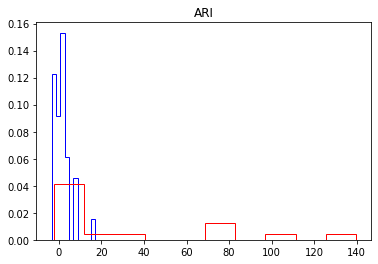

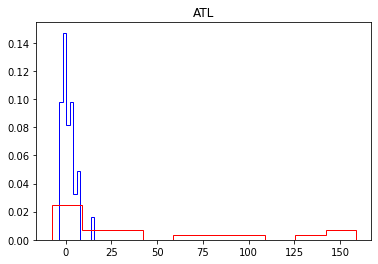

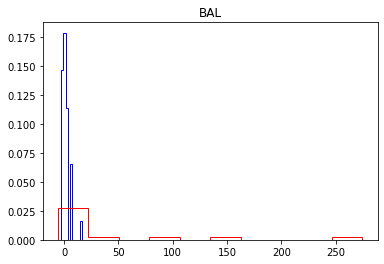

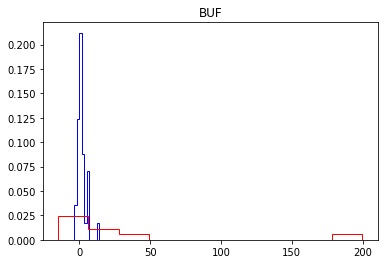

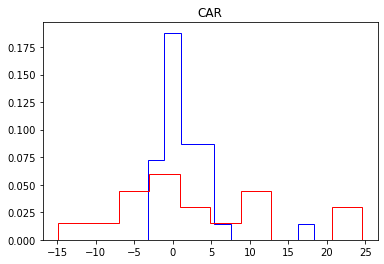

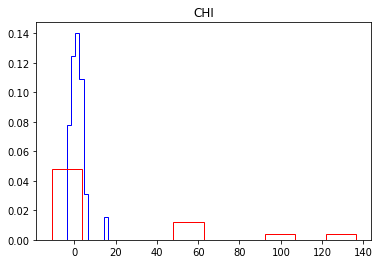

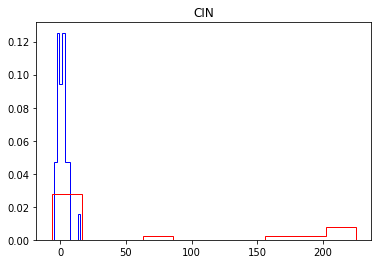

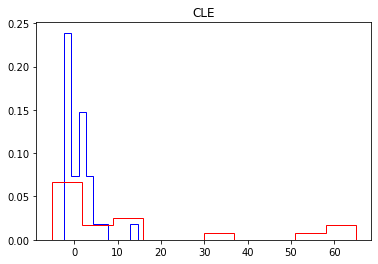

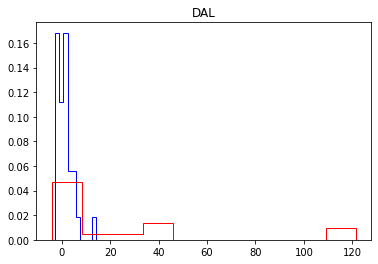

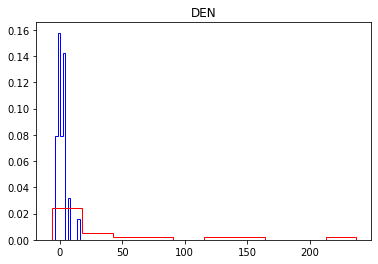

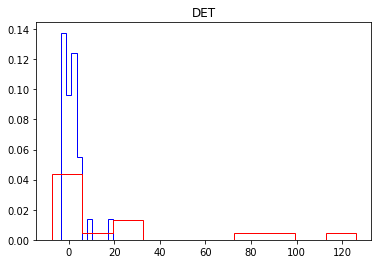

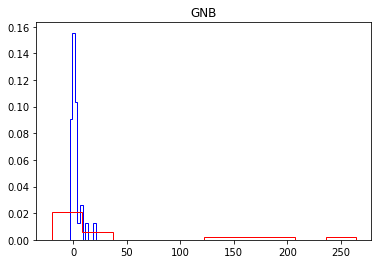

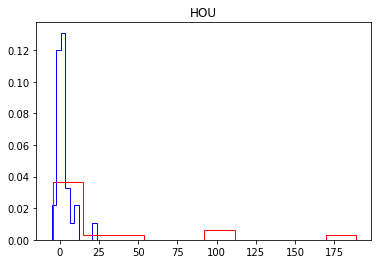

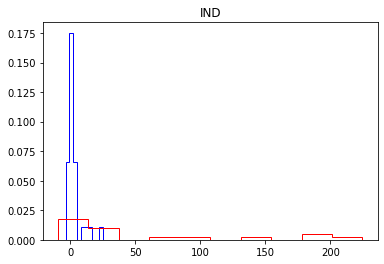

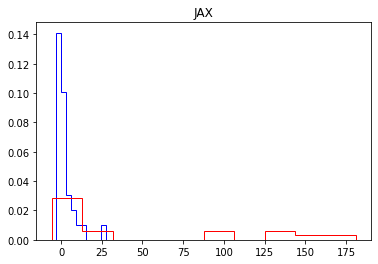

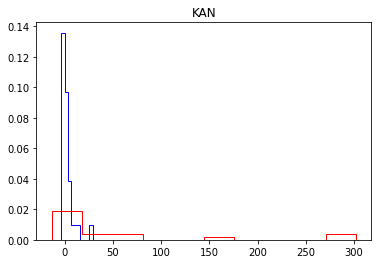

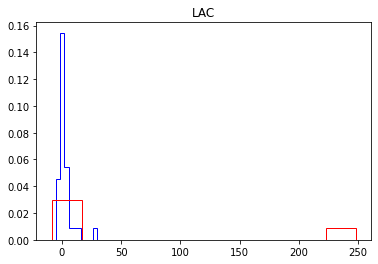

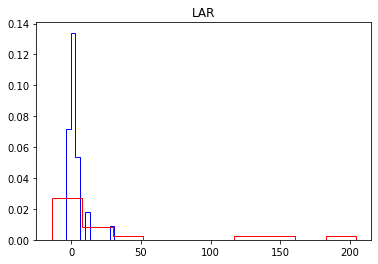

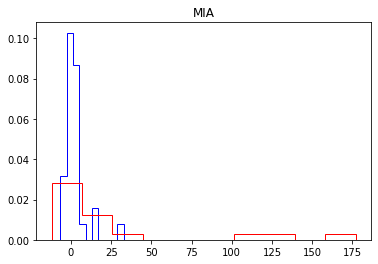

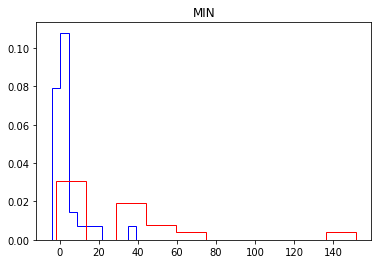

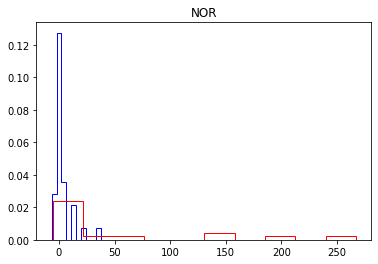

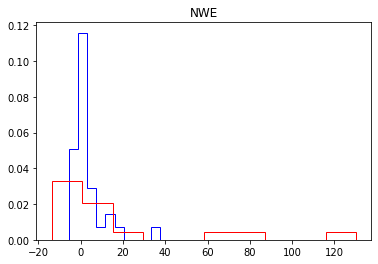

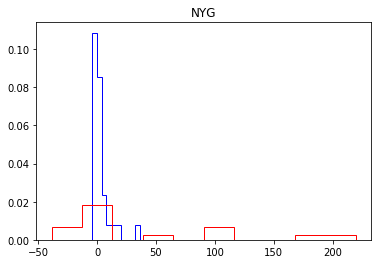

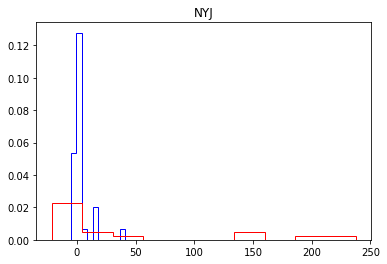

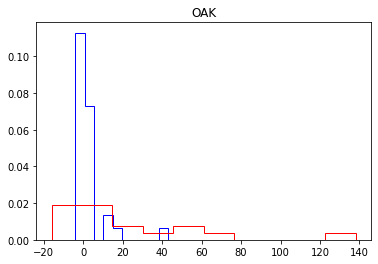

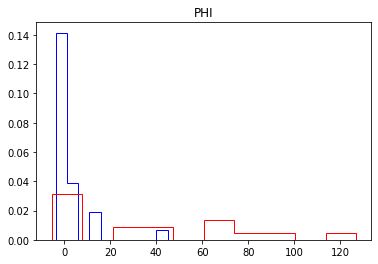

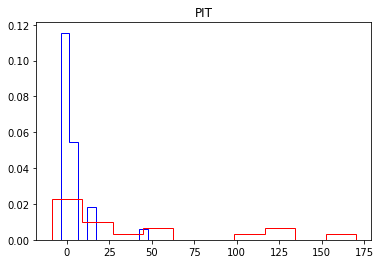

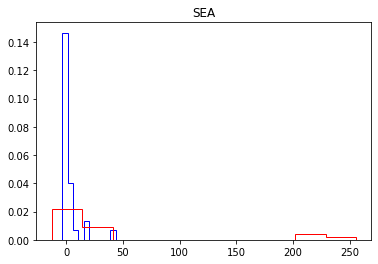

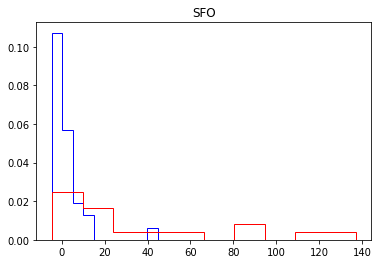

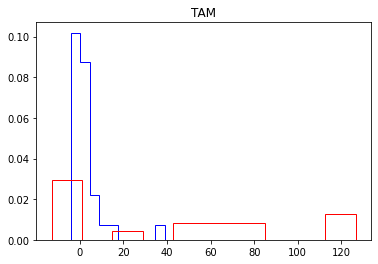

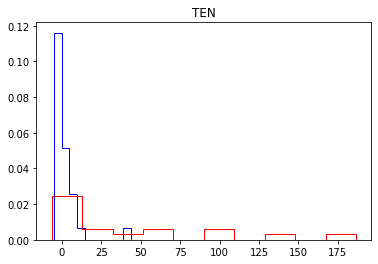

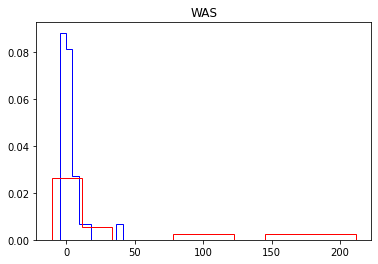

In [15]:
nuts_kernel = NUTS(points_per_player)
mcmc = MCMC(nuts_kernel, warmup_steps=100, num_samples=200)
mcmc.run()
mcmc.summary()
samples = mcmc.get_samples()["points_NY"].numpy()
for i,team in enumerate(all_teams):
    team_samples = samples[i]
    plt.title(team)
    plt.hist(team_samples, density=True, histtype="step", color="blue")
    plt.hist(observed_points_NY[i], density=True, histtype="step", color="red")
    plt.show()

Next, we generate samples from the posterior distribution.

In [22]:
observed_data = {
    "percent_attempts": torch.tensor(observed_percent_attempts.T),
    "percent_attempts_NY": torch.tensor(observed_percent_attempts_NY.T),
    "team_attempts": torch.tensor(observed_attempts.T),
    "team_attempts_NY": torch.tensor(observed_attempts_NY.T),
    "points_NY": torch.tensor(observed_points_NY.T)
}

posterior_model = pyro.condition(points_per_player, data=observed_data)

nuts_kernel = NUTS(posterior_model)
mcmc = MCMC(nuts_kernel, warmup_steps=500, num_samples=1000)
mcmc.run()
mcmc.summary()
samples = mcmc.get_samples()


Sample: 100%|██████████| 1500/1500 [07:16,  3.44it/s, step size=1.43e-01, acc. prob=0.863]



                    mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha[0]      1.32      0.12      1.31      1.13      1.53   1363.29      1.00
      alpha[1]      1.42      0.14      1.41      1.18      1.62   1424.61      1.00
      alpha[2]      1.40      0.14      1.39      1.19      1.63   1426.87      1.00
      alpha[3]      1.26      0.12      1.26      1.05      1.44   1476.70      1.00
      alpha[4]      1.30      0.12      1.30      1.11      1.49   1688.45      1.00
      alpha[5]      1.21      0.10      1.20      1.02      1.36   1452.42      1.00
      alpha[6]      1.34      0.13      1.34      1.13      1.55   1246.77      1.00
      alpha[7]      1.29      0.12      1.29      1.12      1.50   1268.52      1.00
      alpha[8]      1.28      0.12      1.27      1.08      1.47   1345.18      1.00
      alpha[9]      1.36      0.13      1.35      1.17      1.58   1148.68      1.00
     alpha[10]      1.28      0.12      1.28      1.09      1.45

Next we check the posterior distribution.

The posterior distributions look fairly good.  The values are certainly reasonable and generally look like they could be the distribution that generated the data we see.  There are a few important features I will note:


1.   The distribution does a good job capturing the large number of players that have a small number of attempts (say 15 or less).  This is due to the beta distribution that is used to capture the percent attempts each player has on their team; the approximate 4-to-1 success-to-failure pseudocount hyperparameter input is the secret sauce.  
1.   There are a few distributions that do not capture enough of the high number attempts.  This is the case for Baltimore (BAL), Green Bay (GNB), Kansas City (KAN), and New Orleans (NOR).  Between this information and the fact that the prior checks are on the skinny side, it appears that we may need to reparameterize to widen the distribution a bit to the right.  More investigation is necessary, and unfortunatly I did not have enough time to investigate before the deadline.  
1.   Although partial pooling causes the distributions to be different, they are still rather similar.  More investigation is needed here too to figure out whether reparameterizing to make the distributions more team-specific would improve the model.  

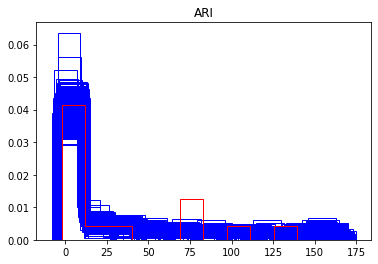

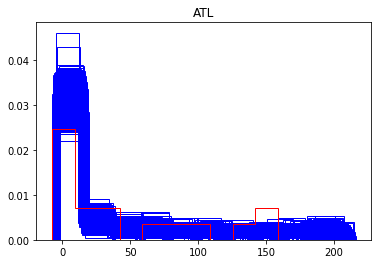

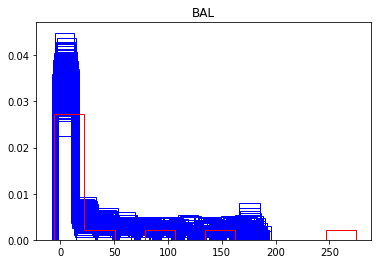

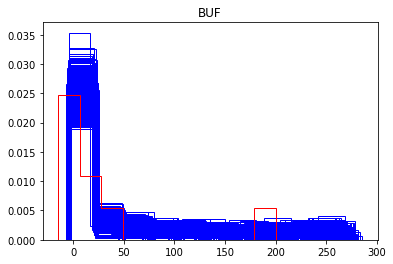

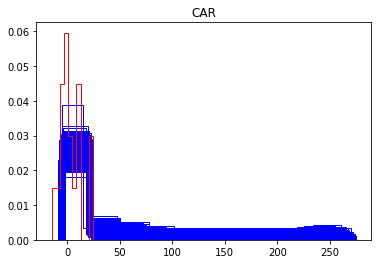

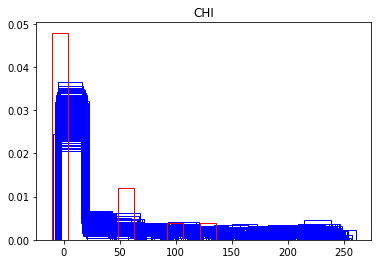

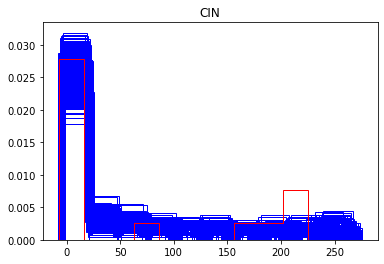

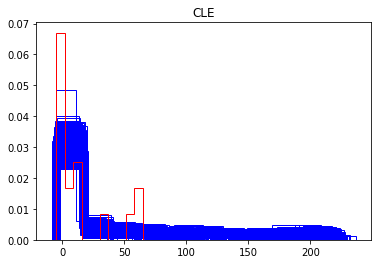

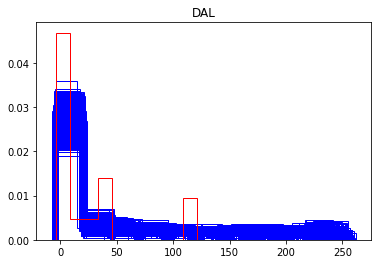

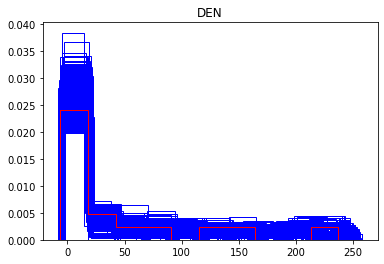

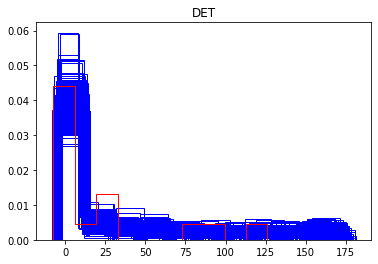

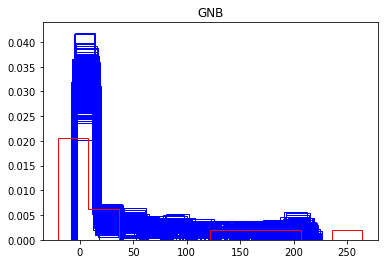

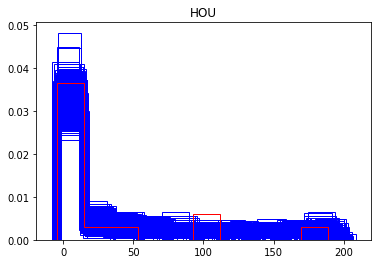

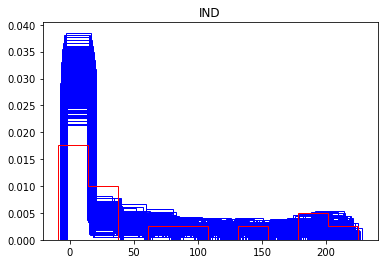

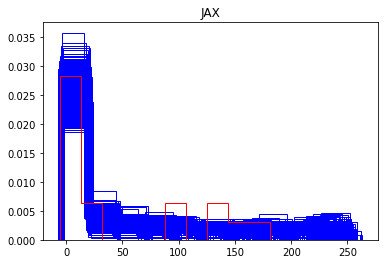

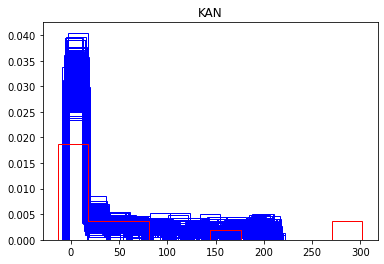

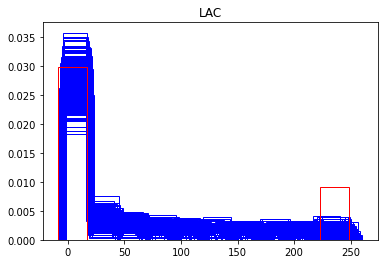

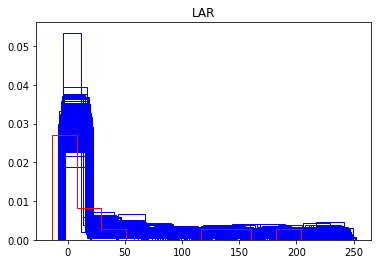

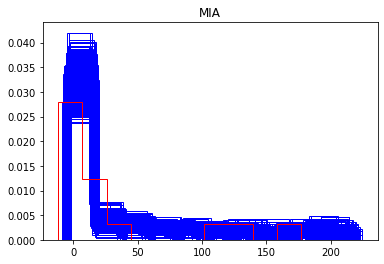

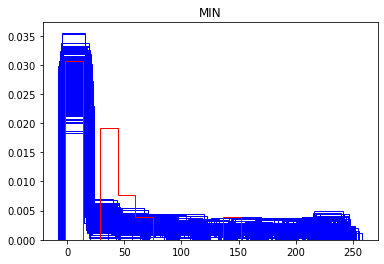

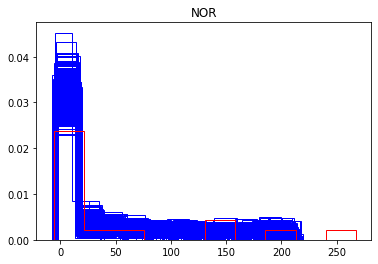

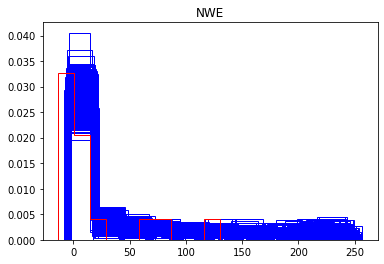

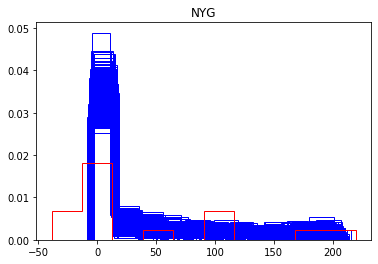

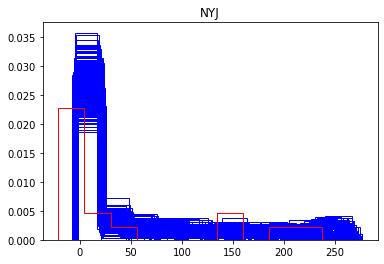

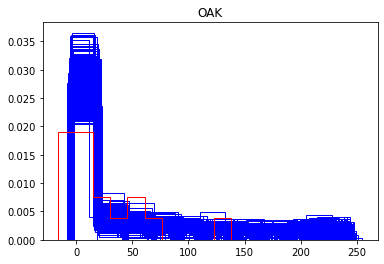

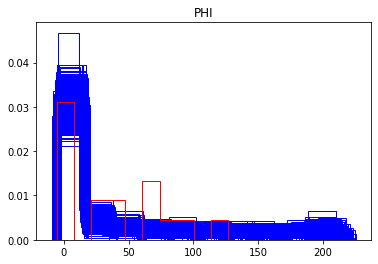

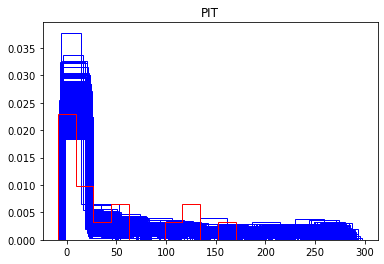

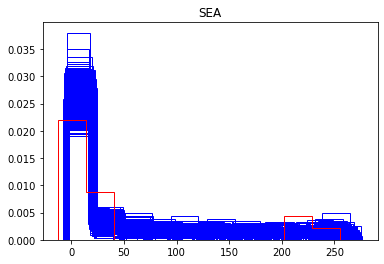

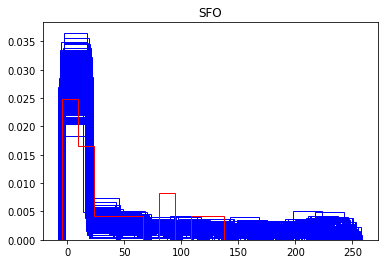

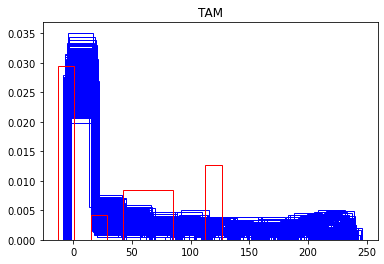

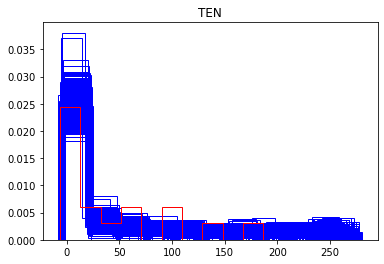

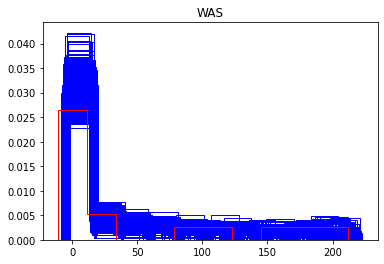

In [23]:
params = [
    samples["league_alpha"].numpy(),
    samples["league_beta"].numpy(),
    samples["alpha"].numpy(),
    samples["beta"].numpy(),
    samples["league_mu"].numpy(),
    samples["mu"].numpy()
]

sims = {}
for i,team in enumerate(all_teams):
    sims[team] = []

for league_alpha, league_beta, alpha, beta, league_mu, mu in zip(*params):
    sim_data = {
        "league_alpha": torch.tensor(league_alpha),
        "league_beta": torch.tensor(league_beta),
        "alpha": torch.tensor(alpha),
        "beta": torch.tensor(beta),
        "league_mu": torch.tensor(league_mu),
        "mu": torch.tensor(mu)
    }
    post_check_model = pyro.condition(points_per_player, data=sim_data)
    team_sims = [[] for _ in range(num_teams)]
    for _ in range(100):
        points_NY = pyro.sample("pny", post_check_model)
        for i in range(num_teams):
            team_sims[i].append(points_NY[i])
    for i,team in enumerate(all_teams):
        sims[team].append(team_sims[i])

for i,team in enumerate(all_teams):
    for team_sims in sims[team]:
        plt.hist(team_sims, density=True, histtype="step", color="blue")
    plt.hist(observed_points_NY[i], density=True, histtype="step", color="red")
    plt.title(team)
    plt.show()

Finally, we use the posterior distribution to create a player ranking.

In [24]:
N = 100
holdout_year = holdout.head(N)
rank = {}
rev_rank = {}

print("".join(["." for _ in range(N)]))

for i,row in holdout_year.iterrows():
    id = row["ID"]
    player = row["Player"]
    percent_att = row["Percent Attempts Of Team"]
    team = row["Team"]
    team_idx = team_to_idx[team]
    sims = []
    for league_alpha, league_beta, alpha, beta, league_mu, mu in zip(*params):
        sim_data = {
            "league_alpha": torch.tensor(league_alpha),
            "league_beta": torch.tensor(league_beta),
            "alpha": torch.tensor(alpha),
            "beta": torch.tensor(beta),
            "league_mu": torch.tensor(league_mu),
            "mu": torch.tensor(mu),
            "percent_attempts": torch.tensor(percent_att)
        }
        pm = pyro.condition(points_per_player, data=sim_data)
        sim = pyro.sample("pm", pm)[team_idx]
        sims.append(sim)
    key = np.mean(sims)
    rank[key] = {"ID": id, "Player": player}
    rev_rank[id] = {"Rank": key, "Player": player}
    print(".", end="")
print()

....................................................................................................
....................................................................................................


In [25]:
true_rank = {}
rev_true_rank = {}
for i,row in holdout_year.iterrows():
    id = row["ID"]
    player = row["Player"]
    key = row["Points Next Year"]
    true_rank[key] = {"ID": id, "Player": player}
    rev_true_rank[id] = {"Rank": key, "Player": player}

This model consistently has a sqrt(MSE) (with 2020 as the holdout set) in the high 50's or low 60's; this is approximately 10 point improvment in sqrt(MSE) from the flat model to the hierarchical model.  

The data scientist who wishes to use cross-validation should be careful with this data-set; simply leaving out some random year as our holdout set does not work because we may be training on years that are later than the holdout year.  I have chosen to simply report the MSE and sqrt(MSE) for this project to keep the analysis simple.  

mse: 3602.8659470146604
mse**0.5: 60.023878140408925


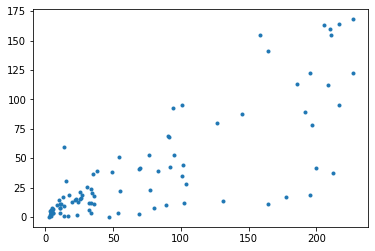

In [26]:
pred = []
diffs = []
for key in reversed(sorted(true_rank.keys())):
    id = true_rank[key]["ID"]
    player = true_rank[key]["Player"]
    predicted = rev_rank[id]["Rank"]
    actual = rev_true_rank[id]["Rank"]
    diff = abs(predicted - actual)
    pred.append(predicted)
    diffs.append(diff)

mse = np.mean([d**2 for d in diffs])
print("mse: {}".format(mse))
print("mse**0.5: {}".format(mse**0.5))

plt.plot(pred, diffs, ".")
plt.show()

In [27]:

print("Projected Rank:")
for k in reversed(sorted(rank.keys())):
    print("{}: {}".format(rank[k]["Player"], k))


Projected Rank:
James Conner: 227.01018651571977
Joe Mixon: 226.93725503085295
Ezekiel Elliott: 216.8711723277656
Christian McCaffrey: 216.57931350912975
Josh Jacobs: 212.40899792188563
Phillip Lindsay: 210.90375322268412
Sony Michel: 210.39293033652976
Chris Carson: 208.66776625969115
Le'Veon Bell: 205.8805103096585
Dalvin Cook: 199.59896838363258
Todd Gurley: 196.462371469084
Leonard Fournette: 195.27806772710233
Nick Chubb: 195.2024988295244
Adrian Peterson: 191.86012693767972
Derrick Henry: 185.85786937184423
Aaron Jones: 177.85784544387604
David Montgomery: 164.43620604980032
Marlon Mack: 164.38297159437383
Devonta Freeman: 164.27576473076408
Saquon Barkley: 158.1812278550566
Carlos Hyde: 145.28293268121087
LeSean McCoy: 136.44726405848368
Melvin Gordon: 130.7954676471649
Kalen Ballage: 126.73930963811777
Frank Gore: 103.48724628704548
Miles Sanders: 102.25231860246802
Austin Ekeler: 101.72486816019999
Ronald Jones II: 100.8745616491452
Tevin Coleman: 100.66211171220183
Mark Ingra